# Наиболее эффективные форматы медиа общения клиентов с банками

__Загрузка библиотек__

In [146]:
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from datetime import datetime
import emoji



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
import pymorphy3
import re
import nltk
import ast

morph = pymorphy3.MorphAnalyzer()

# Set of Russian stopwords
russian_stopwords = set(stopwords.words('russian'))

Создадим словари для дальнейшей обработки

In [55]:
days_in_russian = {
    1: 'Понедельник',  
    2: 'Вторник',      
    3: 'Среда',       
    4: 'Четверг',     
    5: 'Пятница',      
    6: 'Суббота',      
    7: 'Воскресенье'   
}
custom_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

emoji_sentiment = {
    '❤‍🔥': 1,   # positive
    '🙈': 1,     # positive
    '⚡': 1,     # positive
    '🥴': -1,    # negative
    '☃': 0,     # neutral
    '💊': -1,    # negative
    '😘': 1,     # positive
    '💅': 1,     # positive
    '🆒': 1,     # positive
    '🤓': 0,     # neutral
    '😎': 1,     # positive
    '😍': 1,     # positive
    '👏': 1,     # positive
    '💋': 1,     # positive
    '🤗': 1,     # positive
    '🏆': 1,     # positive
    '🍓': 1,     # positive
    '🤪': 1,     # positive
    '❤': 1,      # positive
    '😱': -1,    # negative
    '🙏': 1,     # positive
    '🦄': 1,     # positive
    '🎃': 1,     # positive
    '🙊': 0,     # neutral
    '😢': -1,    # negative
    '🕊': 1,     # positive
    '🍌': 0,     # neutral
    '😨': -1,    # negative
    '💔': 1,   # negative
    '🥱': -1,     # neutral
    '👾': 0,     # neutral
    '😁': 1,     # positive
    '😭': -1,    # negative
    '👍': 1,     # positive
    '🗿': 0,     # neutral
    '👨‍💻': 0,   # neutral
    '🤡': -1,    # negative
    '😐': 0,     # neutral
    '😴': 0,     # neutral
    '🎅': 1,     # positive
    '😈': 1,    # negative
    '👀': 0,     # neutral
    '💯': 1,     # positive
    '🍾': 1,     # positive
    '👌': 1,     # positive
    '🤣': 1,     # positive
    '🎉': 1,     # positive
    '💩': -1,    # negative
    '🤔': 0,     # neutral
    '🤨': 0,     # neutral
    '🤷': 0,     # neutral
    '🥰': 1,     # positive
    '🤬': -1,    # negative
    '👻': 1,     # positive
    '🫡': 0,     # neutral
    '🌭': 1,     # neutral
    '🎄': 1,     # positive
    '👎': -1,    # negative
    '🙉': 1,     # positive
    '🐳': 1,     # positive
    '✍': 0,     # neutral
    '💘': 1,     # positive
    '😡': -1,    # negative
    '🤝': 1,     # positive
    '🤯': 0,     # neutral
    '🤮': -1,    # negative
    '🔥': 1,     # positive
    '🤷‍♂': 0,   # neutral
    '🤩': 1,     # positive
    '🌚': 1,     # neutral
    '😇': 1      # positive
}

In [56]:
df = pd.read_excel("грязные данные все.xlsx")

In [57]:
def parse_reactions(reaction_str):
    # Check if the value is NaN, return an empty dict if so
    if pd.isna(reaction_str):
        return {}
    
    # Convert the string to a list using ast.literal_eval
    reaction_list = ast.literal_eval(reaction_str)
    
    # Create a dictionary to store emoji counts
    reaction_dict = {}
    
    # Iterate through each reaction and store emoji and count
    for reaction in reaction_list:
        # Check if the 'emoji' key exists, otherwise skip
        if 'emoji' in reaction:
            emoji = reaction['emoji']
        elif 'custom_emoji_id' in reaction:
            # Optionally handle custom emojis if needed
            emoji = f"custom_{reaction['custom_emoji_id']}"
        else:
            # Skip if neither 'emoji' nor 'custom_emoji_id' exists
            continue
        
        count = reaction['count']
        reaction_dict[emoji] = count
        
    return reaction_dict


def calculate_emotion(emoji_counts):
    return sum(emoji_sentiment.get(e, 0) * count for e, count in emoji_counts.items())

### Общая обработка данных и фильтрация по датам

In [58]:
def preprocess_df(df):
   
    
    df['media_type'] = df['media'].str.split('.').str[1].str.lower()
    df['date'] = pd.to_datetime(df['date'])
    df['formatted_date'] = df['date'].dt.strftime('%d.%m.%Y')
    df['day_of_week'] = df['date'].dt.weekday + 1
    df['day_of_week_russian'] = df['day_of_week'].map(days_in_russian)
    df['day_of_week_russian'] = pd.Categorical(df['day_of_week_russian'], categories=custom_order, ordered=True)
    df['hour'] = df['date'].dt.hour
    df['text_post'] =  df['text'].str.cat(df['caption'], sep=' ', na_rep='')

    df['reaction_dict'] = df['reactions.reactions'].apply(parse_reactions)
    reactions_df = pd.json_normalize(df['reaction_dict'])
    df['accumulative_reaction'] = df['reaction_dict'].apply(lambda x: calculate_emotion(x))
    df = pd.concat([df, reactions_df], axis=1)
    #df.drop(columns=[ 'reaction_dict'], inplace = True)
    df = df.loc[:, ~df.columns.str.startswith('custom')]


    
    return df
               
               
dfp = preprocess_df(df)
dfp = dfp[dfp.formatted_date < '31.06.2024']   

In [59]:
print(
    "Всего в ходе парсинга была собрано {} постов \n\
    \nДанные отдельно по банкам:\n".format(
    dfp.shape[0],
    )
)

value_counts = dfp['bank'].value_counts()
for factor, count in value_counts.items():
    print(f"{factor} количество постов: {count} ")

Всего в ходе парсинга была собрано 9661 постов 
    
Данные отдельно по банкам:

Московский Кредитный Банк (МКБ) количество постов: 995 
Сбербанк количество постов: 993 
ПСБ Банк количество постов: 992 
Альфа Банк количество постов: 990 
Россельхозбанк (РСХБ) количество постов: 990 
ВТБ Банк количество постов: 986 
Тинькофф Банк количество постов: 986 
Газпромбанк количество постов: 984 
Банк ДОМ.РФ количество постов: 984 
Совкомбанк количество постов: 761 


### Просмотры репосты и средняя реакция

In [61]:
dfp[['views', 'forwards', 'accumulative_reaction']].corr()

,views,forwards,accumulative_reaction
views,1.000000,0.468342,0.395403
forwards,0.468342,1.000000,0.302534
accumulative_reaction,0.395403,0.302534,1.000000


Определенные корреляции между репостами, просмотрами и суммарной реакцией пользователей наблюдаются, однако они не так сильны, корреляция просмотров и репостов можно назвать средней, в корреляция средней реакции пользователей  с просмотрами и репостами можно считать весьма слабой

Топ 10 постов по **просмотрам**

In [62]:
dfp[['media_type', 'text_post', 'bank',  'views']].sort_values('views', ascending = False).head(10)

,media_type,text_post,bank,views
783,video,Обновление 28.09: \n\n⚡️ Бууум! Розыгрыш 50 у...,Сбербанк,5864822.0
609,animation,Обновление 25.12:\n\nРозыгрыш телевизоров Sbe...,Сбербанк,5765494.0
3237,photo,Дарим КЭШБЭК ДО 100% на городской транспорт —...,Альфа Банк,4094024.0
3443,photo,⚡️Возвращаем КЭШБЭК 10% во «Вкусно — и точка»...,Альфа Банк,3970448.0
3213,photo,НЕ ПЛАТИТЕ за проезд — пока не покрутите Бара...,Альфа Банк,3596362.0
3401,photo,У нас не будет скидок только в Чёрную пятницу...,Альфа Банк,3243676.0
3339,photo,Взяли Оскар для работодателей 💎\n\nHeadHunter...,Альфа Банк,3139300.0
3034,photo,,Альфа Банк,3132260.0
3116,video,Зажгли красное солнце. Под его лучами — Альфа...,Альфа Банк,3107935.0
3376,photo,,Альфа Банк,3094270.0


Топ 10 постов по **репостам**

In [63]:
dfp[['media_type', 'text_post', 'bank', 'forwards']].sort_values('forwards', ascending = False).head(10)

,media_type,text_post,bank,forwards
215,NaN,,Сбербанк,67450.0
471,photo,Обновлено: приложение «Учёт Онлайн» больше не...,Сбербанк,62398.0
3774,photo,⚡️ АЛЬФА-БАНК ПЕРВЫМ В СТРАНЕ РАЗДАЁТ ПЛАТЁЖН...,Альфа Банк,30805.0
3771,photo,,Альфа Банк,30375.0
3772,photo,,Альфа Банк,30182.0
3773,photo,,Альфа Банк,30147.0
3250,photo,Открыли Alfa Only Lounge в Шереметьево — лучш...,Альфа Банк,15403.0
3247,photo,,Альфа Банк,15387.0
3248,photo,,Альфа Банк,15359.0
3249,photo,,Альфа Банк,15350.0


Топ 10 постов по **положительности реакции пользователей**

In [64]:
dfp[['media_type', 'text_post','bank',  'accumulative_reaction']].sort_values('accumulative_reaction', ascending = False).head(10)

,media_type,text_post,bank,accumulative_reaction
3330,photo,"Говорят, нельзя заводить отношения на работе....",Альфа Банк,21778
3296,NaN,Альфа-Банк спишет все задолженности по кредита...,Альфа Банк,20201
9420,photo,"Сначала было слово, теперь — буква. \n\nТинь...",Тинькофф Банк,20113
3,NaN,,Сбербанк,15924
3382,NaN,,Альфа Банк,14950
3528,photo,"Искусственный интеллект выяснил, где вкуснее:...",Альфа Банк,12490
3338,photo,⚡️Вернём вам ЕЩЁ БОЛЬШЕ КЭШБЭКА в этом году⚡️...,Альфа Банк,11249
3613,photo,Как Альфа-Банк дошел до кроксов [в конце пост...,Альфа Банк,10753
59,NaN,,Сбербанк,9847
3676,photo,"9 мая — навсегда важный день. День, когда мы ...",Альфа Банк,9498


Текст с наиболее **положительной реакцией пользователей**

In [65]:
print(dfp.sort_values('accumulative_reaction',
                         ascending = False)['text_post'].iloc[0] )
   

 Говорят, нельзя заводить отношения на работе. Но у каждого правила есть исключения ❤

Яна и Дима вместе работали в Альфа-Банке — в команде малого бизнеса. Потом стали ездить в офис вместе — жили на одной ветке метро. А через год после знакомства поженились 💍 

Вместо обручальных колец обменялись платёжными — их подарили коллеги из банка. Теперь ребята носят их каждый день.

Яна говорит, что работать в одном офисе удобно — только жаль, что они с мужем на разных этажах. Зато всегда есть кого отправить за кофе и едой на фудкорт 👀

Что подарить Яне и Диме на годовщину?

❤️ — 100% кэшбэк на второе свадебное путешествие.
👍🏻 — Рабочие места на одном этаже — чтобы Диме было удобно приносить кофе для Яны. 
🔥 — Фарфоровый сервиз, ковёр на стену и набор кастрюлек.

@alfabank


В данном случае это очень креативный пост Альфабанка с видео и замечательным средством маркетинга и пропаганды как `love bombing`.

Наиболее **неприятные** по реакции посты

In [66]:
dfp[['media_type', 'text_post','bank',  'accumulative_reaction']].sort_values('accumulative_reaction').head(10)

,media_type,text_post,bank,accumulative_reaction
573,photo,"Мы заботимся о том, чтобы с нами было комфорт...",Сбербанк,-1218
9176,poll,,Тинькофф Банк,-689
9418,poll,,Тинькофф Банк,-649
9417,NaN,Мы выбираем оба варианта ✨,Тинькофф Банк,-553
6091,NaN,⚡️ Важно!\nС 19 июля расчеты по картам платежн...,Россельхозбанк (РСХБ),-493
9556,photo,"Шутки шутками, а Сергей Орлов совместно с Тин...",Тинькофф Банк,-329
9416,video_note,,Тинькофф Банк,-329
5235,poll,,Московский Кредитный Банк (МКБ),-265
5064,poll,,Московский Кредитный Банк (МКБ),-257
9195,poll,,Тинькофф Банк,-245


In [68]:
print(dfp.sort_values('accumulative_reaction')['text_post'].iloc[0] )

 Мы заботимся о том, чтобы с нами было комфортно каждому жителю страны ✨

Предлагаем познакомиться с нашими новыми банковскими продуктами по стандартам исламского финансирования.

Они созданы специально для всех, кому важно соблюдать определенные этические нормы и в жизни, и в бизнесе  ✅


Внимание на слово **исламский**

In [69]:
for i in dfp.sort_values('accumulative_reaction')['text_post'].head(15):
    if len(i) > 1:
        print(i)
        print('- -' * 10 )

 Мы заботимся о том, чтобы с нами было комфортно каждому жителю страны ✨

Предлагаем познакомиться с нашими новыми банковскими продуктами по стандартам исламского финансирования.

Они созданы специально для всех, кому важно соблюдать определенные этические нормы и в жизни, и в бизнесе  ✅
- -- -- -- -- -- -- -- -- -- -
Мы выбираем оба варианта ✨ 
- -- -- -- -- -- -- -- -- -- -
⚡️ Важно!
С 19 июля расчеты по картам платежной системы UnionPay, выпущенным РСХБ, за рубежом будут приостановлены.

Если вы за пределами России, рекомендуем до указанной даты снять наличные с карт UnionPay.

Напоминаем о наличии суточных лимитов на снятие наличных, в том числе на стороне банка-владельца банкомата. Лимиты РСХБ на снятие наличных размещены на сайте банка в разделе Дебетовая карта СВОЯ.

На территории России карты работают без ограничений. Будем дополнительно информировать вас обо всех изменениях.

#РСХБ 
- -- -- -- -- -- -- -- -- -- -
 Шутки шутками, а Сергей Орлов совместно с Тинькофф Банком выпус

В общем - ксенофобия, плохие новости для клиентов и навязчивая реклама.

### Время публикации поста

#### День недели

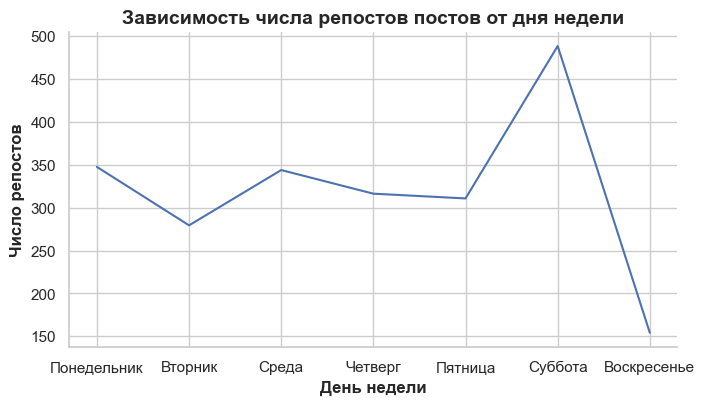

In [70]:
days_stat = dfp.groupby('day_of_week_russian' ,observed=False ,
                        as_index = False)[['forwards', 'views', 'accumulative_reaction' ]].mean()



sns.relplot(data = days_stat, x = 'day_of_week_russian', y = 'forwards', 
            kind= 'line', height=4,  aspect=1.8);
plt.title('Зависимость числа репостов постов от дня недели', fontsize=14, fontweight ='bold')
plt.xlabel('День недели', fontsize=12,  fontweight ='bold')
plt.ylabel('Число репостов', fontsize=12, fontweight ='bold')
plt.show();

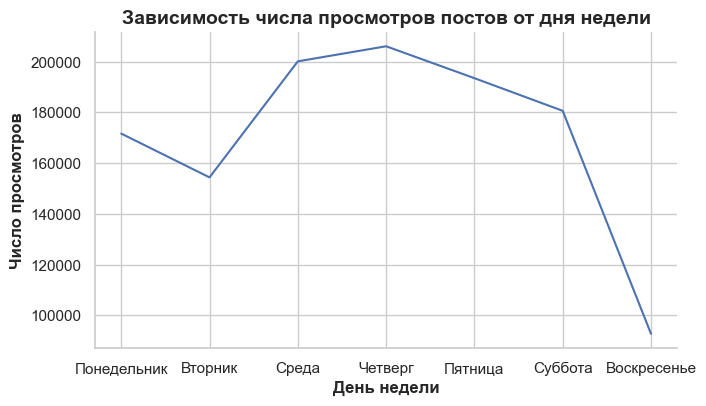

In [71]:
sns.relplot(data = days_stat, x = 'day_of_week_russian', y = 'views', 
            kind= 'line', height=4,  aspect=1.8);
plt.title('Зависимость числа просмотров постов от дня недели', fontsize=14, fontweight ='bold')
plt.xlabel('День недели', fontsize=12,  fontweight ='bold')
plt.ylabel('Число просмотров', fontsize=12, fontweight ='bold')
plt.show();

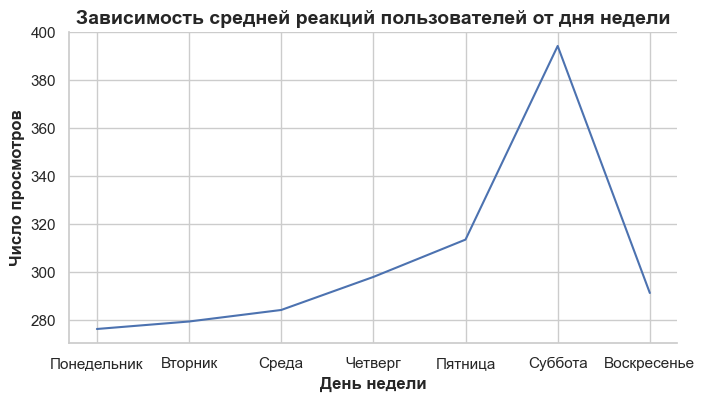

In [72]:
sns.relplot(data = days_stat, x = 'day_of_week_russian', y = 'accumulative_reaction', 
            kind= 'line', height=4,  aspect=1.8);
plt.title('Зависимость средней реакций пользователей от дня недели', fontsize=14, fontweight ='bold')
plt.xlabel('День недели', fontsize=12,  fontweight ='bold')
plt.ylabel('Число просмотров', fontsize=12, fontweight ='bold')
plt.show();

Теперь посмотрим только отрицательный реакции по дням.

In [76]:
dfp[dfp.accumulative_reaction < 1].groupby('day_of_week_russian',
                                           observed = False,
                                           as_index = False)['accumulative_reaction'].mean()


,day_of_week_russian,accumulative_reaction
0,Понедельник,-3.339713
1,Вторник,-1.443149
2,Среда,-1.520631
3,Четверг,-3.467123
4,Пятница,-1.768246
5,Суббота,-0.600897
6,Воскресенье,-3.738636


Интересно, что число репостов достигает максимума в субботу, далее оно начинает падать в воскресение, вплоть до вторника. Потом небольшой подъем в среду, падение в четверг и пятницу. Похожий паттерн по средней реакции пользователей - она медленно становится все более положительной вплоть до пятницы, где идет очень резкий рост до максимума, субботы, и вновь падение в воскресение. 

На самом деле это звучит весьма логично, в выходные больше свободного времени, например для общения, и в том числе для пересылки поста. В выходные дни больше положительных эмоций -  таковы и реакции.

А вот число просмотров не так ясно - рост до четверга (максимум), а далее падение. 

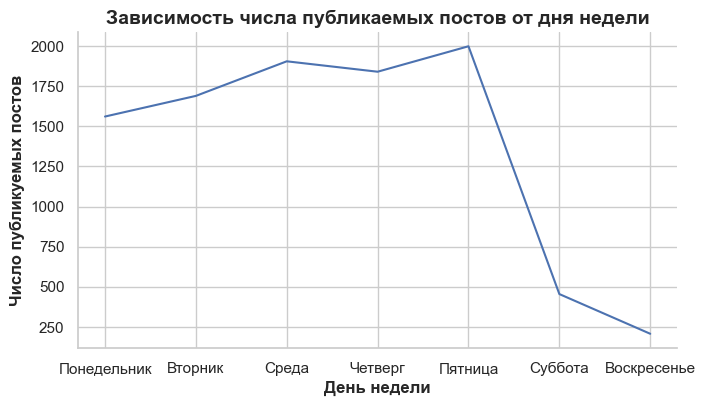

In [77]:
days_stat = dfp.groupby('day_of_week_russian',
            observed=False, 
            as_index = False).size()


sns.relplot(data = days_stat, x = 'day_of_week_russian', y = 'size', 
            kind= 'line', height=4,  aspect=1.8);
plt.title('Зависимость числа публикаемых постов от дня недели', fontsize=14, fontweight ='bold')
plt.xlabel('День недели', fontsize=12,  fontweight ='bold')
plt.ylabel('Число публикуемых постов', fontsize=12, fontweight ='bold')
plt.show();

И как мы можем увидеть банки понимают выводы выше, и в среднем публикуют максимальное число постов  в пятницу, чтобы пользователи прочитали их в субботу.

#### Час дня

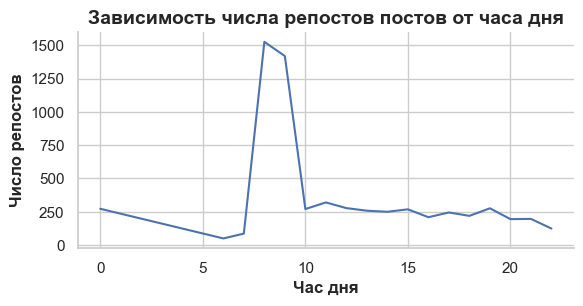

In [78]:
hours_stat = dfp.groupby('hour' ,observed=False ,
                        as_index = False)[['forwards', 'views',  'accumulative_reaction'  ]].mean()

sns.relplot(data = hours_stat, x = 'hour', y = 'forwards', 
            kind= 'line', height=3,  aspect=2);
plt.title('Зависимость числа репостов постов от часа дня', fontsize=14, fontweight ='bold')
plt.xlabel('Час дня', fontsize=12,  fontweight ='bold')
plt.ylabel('Число репостов', fontsize=12, fontweight ='bold')
plt.show();

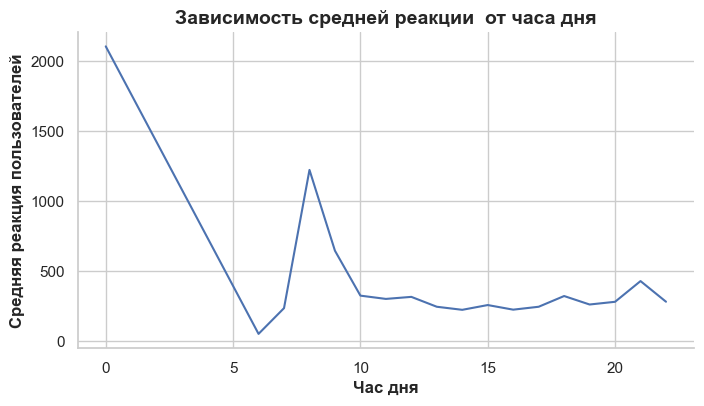

In [89]:
sns.relplot(data = hours_stat, x = 'hour', y = 'accumulative_reaction', 
            kind= 'line', height=4,  aspect=1.8);
plt.title('Зависимость средней реакции  от часа дня', fontsize=14, fontweight ='bold')
plt.xlabel('Час дня', fontsize=12,  fontweight ='bold')
plt.ylabel('Средняя реакция пользователей', fontsize=12, fontweight ='bold')
plt.show();

Пользователи чаще всего репостят посты, которые опубликованы утром -  в 8-9 утра. То есть люди, только проснувшись, открывают  Telegram и в этот  момент больше всего репостов постов, также это время завтра и пути на работу.

А вот наиболее положительны реакции ставятся для постов, опубликованных после уже глубокой ночью и также в 8-9 утра, третий пик в 9 вечера  значительно меньше первых двух. Второй пик совпал с пиком репостов. 

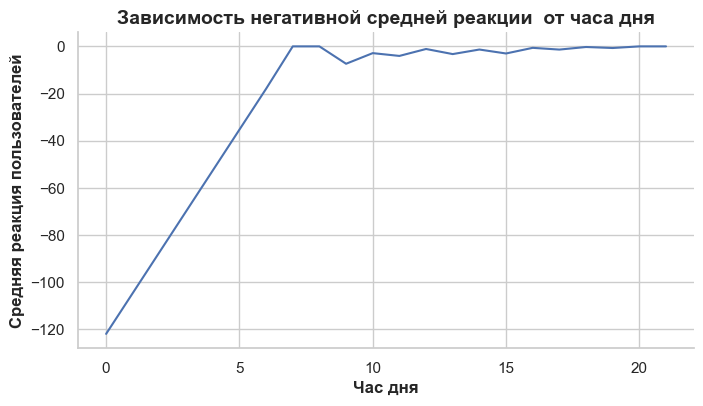

In [88]:
negative_hours_stat = dfp[dfp.accumulative_reaction < 1].groupby('hour',
                                           observed = False,
                                           as_index = False)['accumulative_reaction'].mean()

sns.relplot(data = negative_hours_stat, x = 'hour', y = 'accumulative_reaction', 
            kind= 'line', height=4,  aspect=1.8);
plt.title('Зависимость негативной средней реакции  от часа дня', fontsize=14, fontweight ='bold')
plt.xlabel('Час дня', fontsize=12,  fontweight ='bold')
plt.ylabel('Средняя реакция пользователей', fontsize=12, fontweight ='bold')
plt.show();

Наиболее негативные реакции тоже ставятся глубоконо ночью

#### День недели и час

In [98]:
for i in dfp.columns:
    if 'reaction' in i:
        print(i)

reactions._
reactions.reactions
pinned_message.reactions._
pinned_message.reactions.reactions
reaction_dict
accumulative_reaction


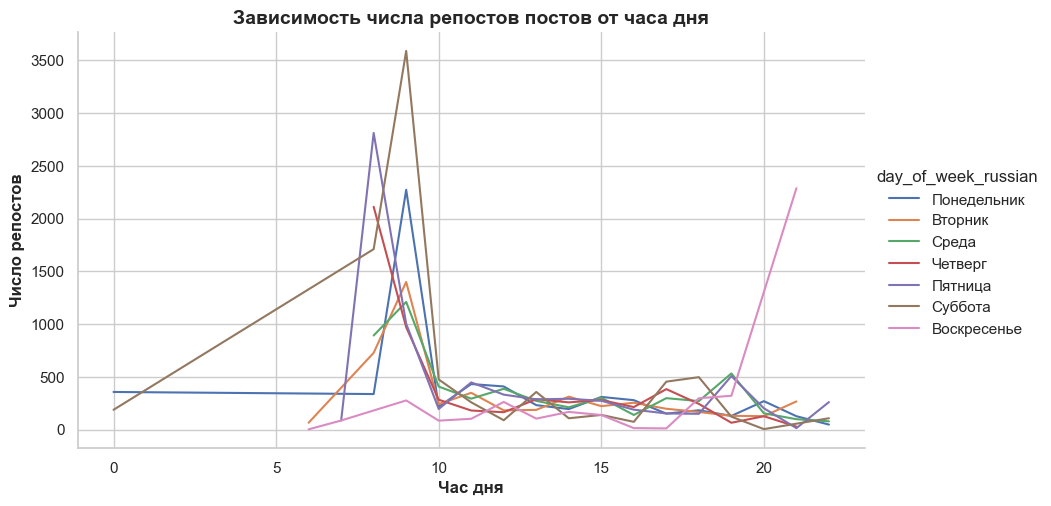

In [101]:
palette_days =['#e6194b', '#3cb44b', '#e6194B', '#4363d8', '#f58231', '#911eb4', '#f032e6']
days_stat = dfp.groupby(['day_of_week_russian', 'hour' ],observed=False ,
                        as_index = False)[['forwards', 'accumulative_reaction' ]].mean()

sns.relplot(data = days_stat, x = 'hour', y = 'forwards', hue = 'day_of_week_russian', 
            kind= 'line', height=5,  aspect=1.8);
plt.title('Зависимость числа репостов постов от часа дня', fontsize=14, fontweight ='bold')
plt.xlabel('Час дня', fontsize=12,  fontweight ='bold')
plt.ylabel('Число репостов', fontsize=12, fontweight ='bold')
plt.show();

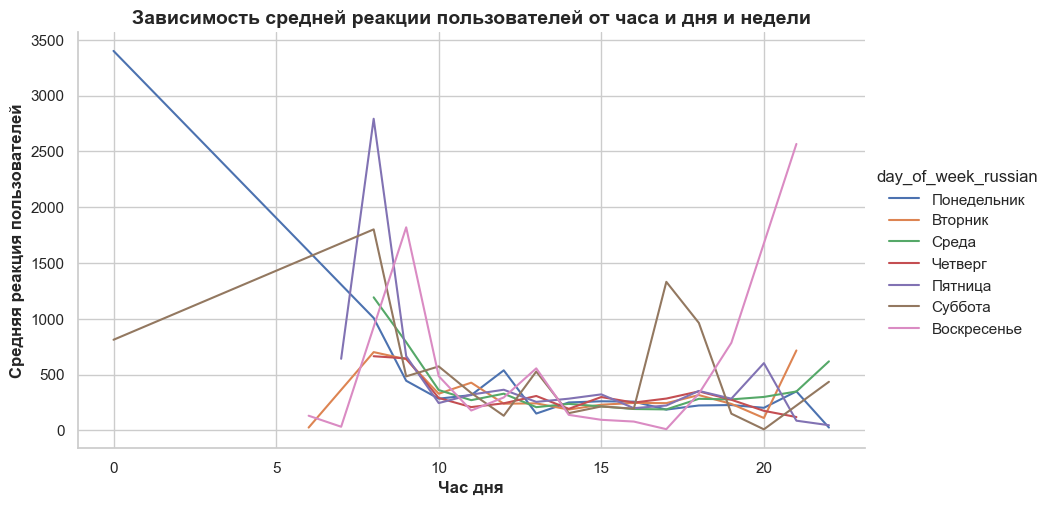

In [103]:

sns.relplot(data = days_stat, x = 'hour', y = 'accumulative_reaction', hue = 'day_of_week_russian', 
            kind= 'line', height=5,  aspect=1.8);
plt.title('Зависимость средней реакции пользователей от часа и дня и недели', fontsize=14, fontweight ='bold')
plt.xlabel('Час дня', fontsize=12,  fontweight ='bold')
plt.ylabel('Средняя реакция пользователей', fontsize=12, fontweight ='bold')
plt.show();

По дням недели пик позитива в реакциях случается в самом начале понедельника, вернее в ночь с воскресение на понедельник. Другой важные пики - утро пятницы, субботы и воскресения. Также примерно послеобеденное время в субботу, ночь воскресения, которая плавно перетекате в первые часы понедельника.

### Формат медиа

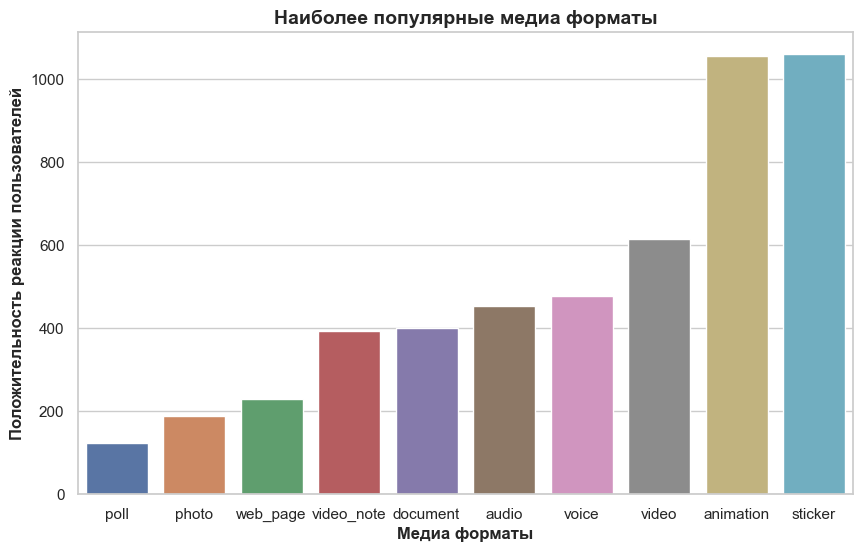

In [125]:
plt.figure(figsize=(10,6))

dfps = dfp.groupby('media_type',
                    as_index = False)[['forwards', 'views', 'accumulative_reaction']]\
.mean().sort_values('accumulative_reaction')

sns.barplot(data = dfps, x = 'media_type', y = 'accumulative_reaction', hue = 'media_type' );
plt.title('Наиболее популярные медиа форматы', fontsize=14, fontweight ='bold');
plt.xlabel('Медиа форматы', fontsize=12,  fontweight ='bold');
plt.ylabel('Положительность реакции пользователей', fontsize=12, fontweight ='bold');
plt.show();

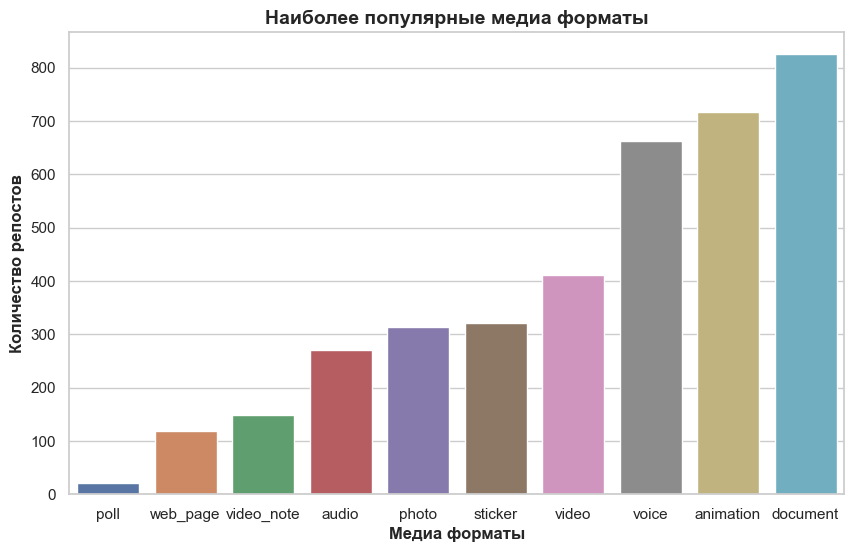

In [126]:
dfps = dfps.sort_values('forwards')

plt.figure(figsize=(10,6))



sns.barplot(data = dfps, x = 'media_type', y = 'forwards', hue = 'media_type' );
plt.title('Наиболее популярные медиа форматы', fontsize=14, fontweight ='bold');
plt.xlabel('Медиа форматы', fontsize=12,  fontweight ='bold');
plt.ylabel('Количество репостов', fontsize=12, fontweight ='bold');
plt.show();


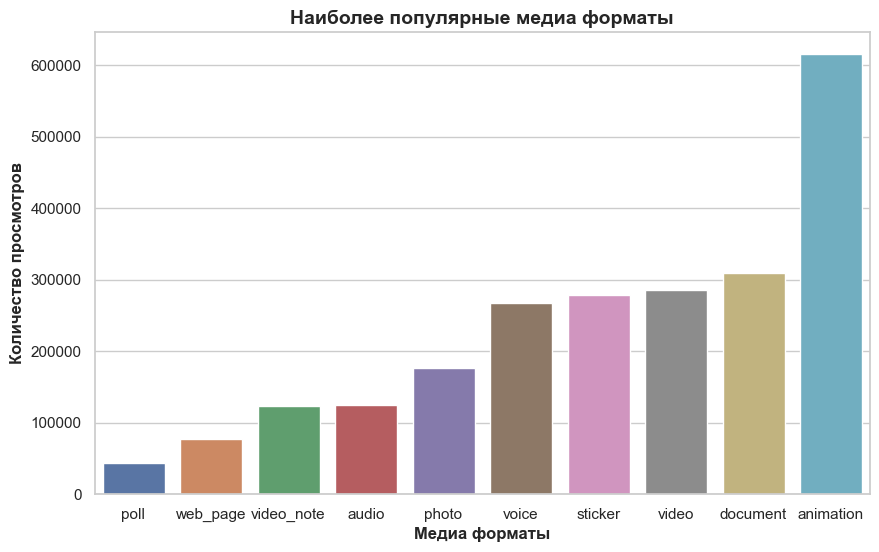

In [127]:
dfps = dfps.sort_values('views')

plt.figure(figsize=(10,6))



sns.barplot(data = dfps, x = 'media_type', y = 'views', hue = 'media_type' );
plt.title('Наиболее популярные медиа форматы', fontsize=14, fontweight ='bold');
plt.xlabel('Медиа форматы', fontsize=12,  fontweight ='bold');
plt.ylabel('Количество просмотров', fontsize=12, fontweight ='bold');
plt.show();


С точки зрения положительной реакции лучший формат это стикер. Так как реакция и стикер можно считать наиболее близкими форматами, звучит весьма логично. И более того, помним, что от первых реакций первых пользователей зависят дальнейшие реакций, которые будут поставлены более поздними читателями поста ( то есть в таком формате самыми первым реакцию ставит сам банк, полностью контролируя, что будет дальше).

С точки зрения репостов наиболее популярны документы (то есть текстовые файлы, прикрепленный к посту). В них, например, могут излагаться выгодные предложения, условия, которые пользователи могут переслать своим друзьям родственникам. 

Самый лучший формат для просмотров - это анимация. Соответственно анимации, голосовые сообщения и стикеры и видео можно считать самыми лучшими форматами с точки зрения всех трех показателей.

### Текст поста

In [135]:
text_data = dfp[dfp.text.notnull () ][['id', 'text_post', 'views','forwards', 'accumulative_reaction']]

In [147]:


# Preprocessing function
def preprocess_text(text):
    # 1. Lowercase the text
    text = text.lower()
    
    # 2. Remove non-alphabetic characters (punctuation, numbers, etc.)
    text = re.sub(r'[^а-яё]', ' ', text)
    
    # 3. Tokenization (split by whitespace)
    tokens = text.split()
    
    # 4. Lemmatization and stopword removal
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    
    # 5. Return the processed text as a single string
    return ' '.join(lemmatized_tokens)




In [143]:
text_data['cleaned'] = text_data['text_post'].apply(lambda x: pre

tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(text_data['text_post']).toarray

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

text_data['cluster'] = clusters

TypeError: float() argument must be a string or a real number, not 'method'

In [144]:
X

<bound method _cs_matrix.toarray of <1190x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 37438 stored elements in Compressed Sparse Row format>>

### Анимации

<Axes: xlabel='animation.duration', ylabel='forwards'>

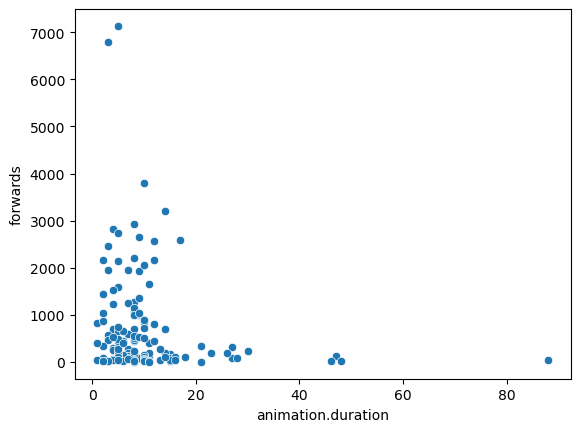

In [9]:
sns.scatterplot(data = s, x = 'animation.duration', y = 'forwards')

### Войс (голосовое сообщение)

<Axes: xlabel='voice.duration', ylabel='forwards'>

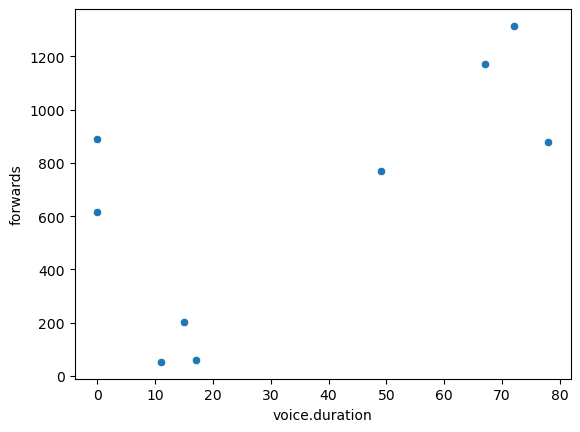

In [11]:
sns.scatterplot(data = s, x = 'voice.duration', y = 'forwards')

### Видео

### Стикер

### Фото 

### Audio

### Финальные выводы